# EmployeePayHistory

## Import the necessary libraries

In [53]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [54]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading in the data

In [55]:
sql_query_orderheader = "SELECT * FROM SalesOrderHeader"
orderheader_df = read_data_return_df(sql_query_orderheader, engine)

orderheader_df.head()

,SALESORDERHEADER_sk,SALESORDERHEADER_SALESORDERDETAIL_SalesOrderID,SALESORDERHEADER_SALESORDERDETAIL_SalesOrderDetailID,SALESORDERHEADER_SALESORDERDETAIL_CarrierTrackingNumber,SALESORDERHEADER_SALESORDERDETAIL_OrderQty,SALESORDERHEADER_SALESORDERDETAIL_ProductID,SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID,SALESORDERHEADER_SALESORDERDETAIL_UnitPrice,SALESORDERHEADER_SALESORDERDETAIL_UnitPriceDiscount,SALESORDERHEADER_SALESORDERDETAIL_LineTotal,...,SALESORDERHEADER_SALESORDER_CustID,SALESORDERHEADER_SALESORDER_OrderDate,SALESORDERHEADER_SALESORDER_Region,SALESORDERHEADER_SALESORDER_SalesRep,SALESORDERHEADER_SALESORDERITEM_SalesOrderItemID,SALESORDERHEADER_SALESORDERITEM_LineID,SALESORDERHEADER_SALESORDERITEM_ProdID,SALESORDERHEADER_SALESORDERITEM_Quantity,SALESORDERHEADER_SALESORDERITEM_ShipDate,SALESORDERHEADER_datetime_added
0,1,43697.0,353.0,None,1.0,479.0,288.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-28 09:42:46.237
1,2,43697.0,353.0,None,1.0,479.0,288.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-28 09:42:46.243
2,3,43702.0,358.0,None,1.0,485.0,288.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-28 09:42:46.250
3,4,43702.0,358.0,None,1.0,485.0,288.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-28 09:42:46.253
4,5,43703.0,359.0,None,1.0,479.0,288.0,3578.27,0.0,3578.27,...,NaN,None,None,NaN,NaN,NaN,NaN,NaN,None,2024-05-28 09:42:46.260


## Data Cleaning

In [56]:
# dropping unnecessary columns
columns_to_keep = ['SALESORDERHEADER_sk', 'SALESORDERHEADER_SALESORDERDETAIL_OrderQty', 'SALESORDERHEADER_SALESORDERDETAIL_ProductID', 'SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID', 'SALESORDERHEADER_SALESORDERDETAIL_UnitPrice', 'SALESORDERHEADER_SALESORDERDETAIL_UnitPriceDiscount', 'SALESORDERHEADER_SALESORDERDETAIL_LineTotal', 'SALESORDERHEADER_SALESORDERHEADER_TerritoryID']

combined_df = orderheader_df[columns_to_keep]

In [57]:
# fixing null values
drop_columns(combined_df)

In [58]:
# converting types
combined_df['SALESORDERHEADER_SALESORDERDETAIL_OrderQty'] = combined_df['SALESORDERHEADER_SALESORDERDETAIL_OrderQty'].astype('int')

combined_df['SALESORDERHEADER_SALESORDERDETAIL_ProductID'] = combined_df['SALESORDERHEADER_SALESORDERDETAIL_ProductID'].astype('int').astype('category').cat.codes
combined_df['SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID'] = combined_df['SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID'].astype('int').astype('category').cat.codes
combined_df['SALESORDERHEADER_SALESORDERHEADER_TerritoryID'] = combined_df['SALESORDERHEADER_SALESORDERHEADER_TerritoryID'].astype('int').astype('category').cat.codes

In [59]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69979 entries, 0 to 69978
Data columns (total 7 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   SALESORDERHEADER_SALESORDERDETAIL_OrderQty           69979 non-null  int32  
 1   SALESORDERHEADER_SALESORDERDETAIL_ProductID          69979 non-null  int8   
 2   SALESORDERHEADER_SALESORDERDETAIL_SpecialOfferID     69979 non-null  int8   
 3   SALESORDERHEADER_SALESORDERDETAIL_UnitPrice          69979 non-null  float64
 4   SALESORDERHEADER_SALESORDERDETAIL_UnitPriceDiscount  69979 non-null  float64
 5   SALESORDERHEADER_SALESORDERDETAIL_LineTotal          69979 non-null  object 
 6   SALESORDERHEADER_SALESORDERHEADER_TerritoryID        69979 non-null  int8   
dtypes: float64(2), int32(1), int8(3), object(1)
memory usage: 2.1+ MB


## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [60]:
# splitting the data
X = combined_df.drop(columns=['SALESORDERHEADER_SALESORDERDETAIL_OrderQty'])
y = combined_df['SALESORDERHEADER_SALESORDERDETAIL_OrderQty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [61]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [63]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [64]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 6.124245860733963e-29
R2 Score: 1.0


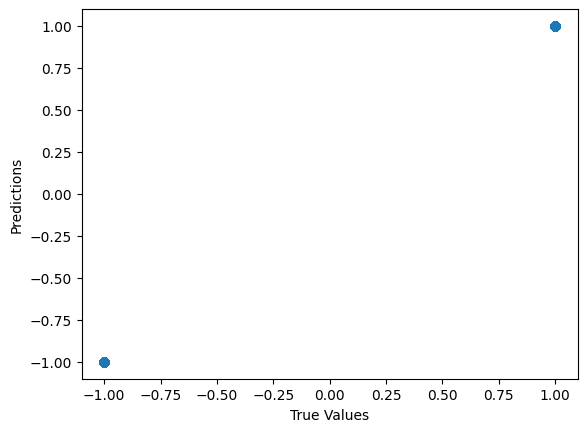

In [65]:
# visualizing the results
plt.scatter(y_test, lr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [66]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
9736,1,1.0,3.774758e-15,3.774758e-15,1.424880e-29
37530,1,1.0,-2.975398e-14,2.975398e-14,8.852992e-28
22230,1,1.0,1.998401e-15,1.998401e-15,3.993608e-30
61685,1,1.0,2.109424e-15,2.109424e-15,4.449669e-30
12950,1,1.0,6.883383e-15,6.883383e-15,4.738096e-29
...,...,...,...,...,...
3620,1,1.0,3.108624e-15,3.108624e-15,9.663546e-30
57405,1,1.0,1.998401e-15,1.998401e-15,3.993608e-30
53756,1,1.0,4.440892e-16,4.440892e-16,1.972152e-31
31861,1,1.0,2.775558e-15,2.775558e-15,7.703720e-30


### Decision Tree Regressor

In [67]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [68]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [69]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 0.0
R2 Score: 1.0


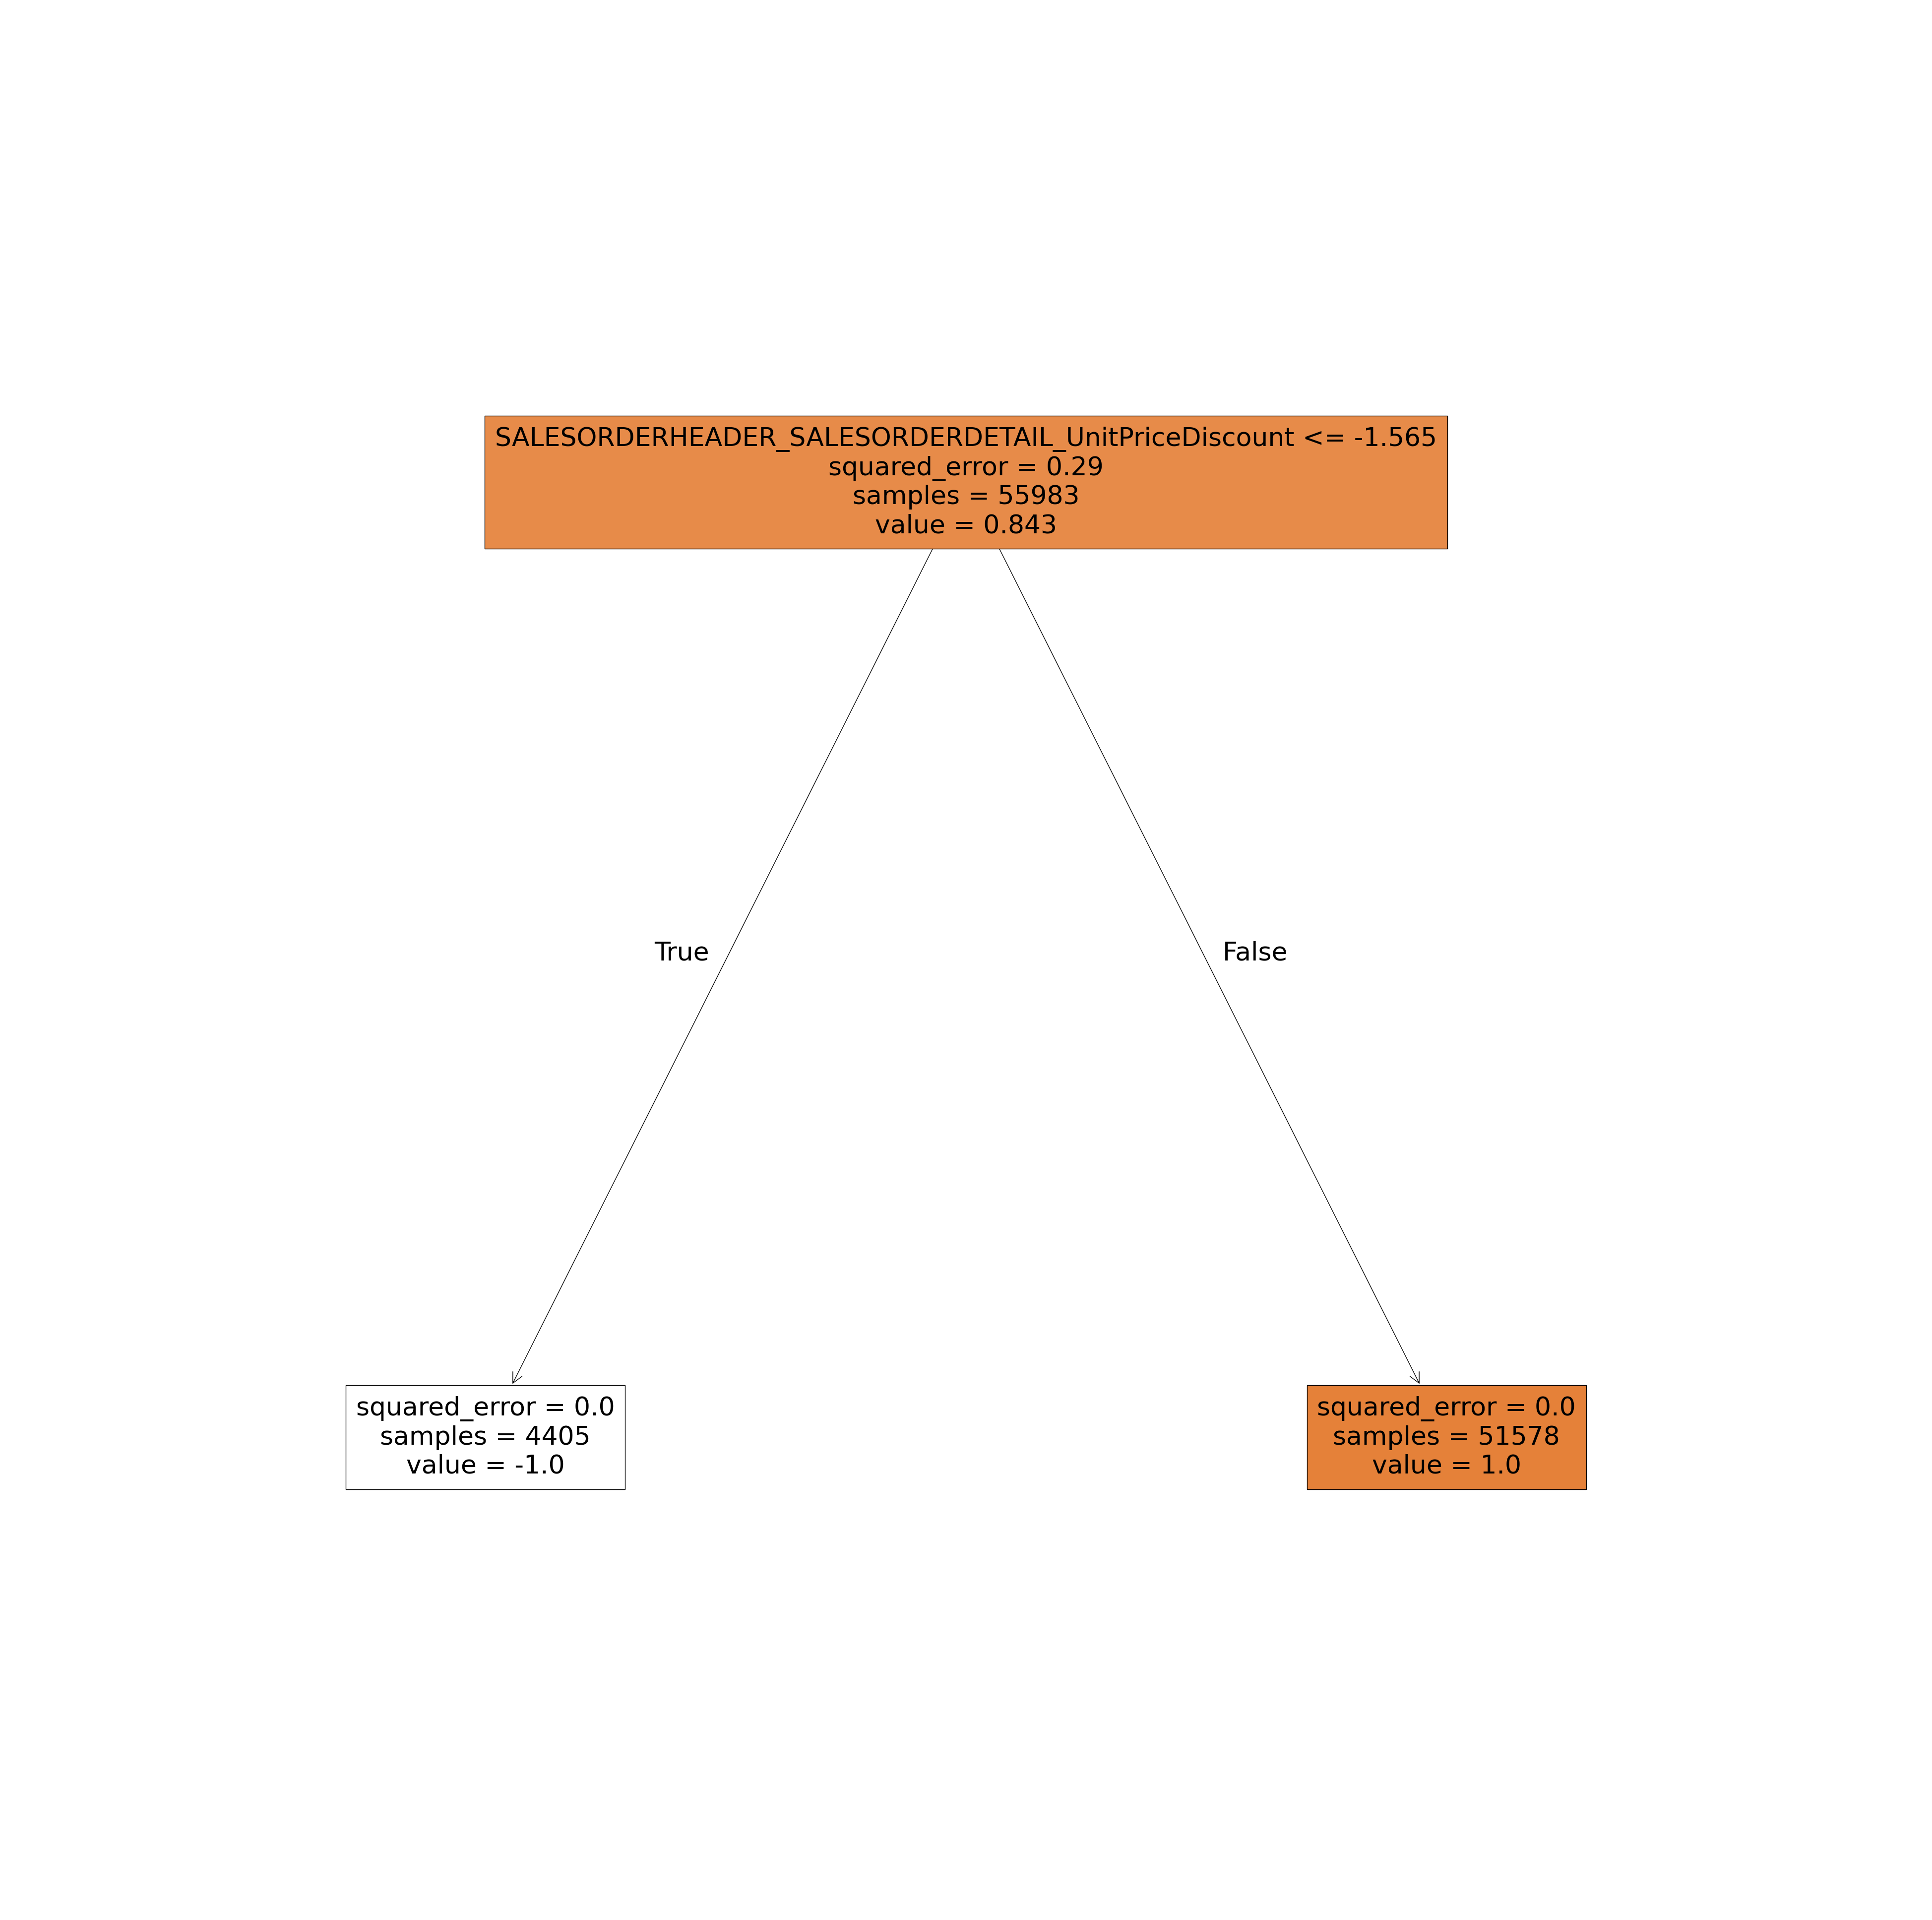

In [70]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [71]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
9736,1,1.0,0.0,0.0,0.0
37530,1,1.0,0.0,0.0,0.0
22230,1,1.0,0.0,0.0,0.0
61685,1,1.0,0.0,0.0,0.0
12950,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...
3620,1,1.0,0.0,0.0,0.0
57405,1,1.0,0.0,0.0,0.0
53756,1,1.0,0.0,0.0,0.0
31861,1,1.0,0.0,0.0,0.0


### Pytorch Neural Network

In [72]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cpu


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

#### Calculating the metrics and visualizing the results

In [ ]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        
        # Only calculate R^2 score if there are more than one samples
        if len(targets) > 1:
            r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list) if p_r2_list else None

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

In [ ]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results